# Importation Station

In [81]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.cross_validation import train_test_split
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.svm import LinearSVC, SVC
from imblearn.under_sampling import RandomUnderSampler

plt.style.use("seaborn")
%matplotlib inline

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 28.5 ms


# Make DataFrame and Extract Features

## Read Initial Data

In [82]:
# df= pd.read_csv("us-perm-visas.zip")
# df.head()

time: 501 µs


## Extract Features of Interest

In [83]:
# df_feat=df[['class_of_admission','country_of_citizenship',
#             'country_of_citzenship','case_status', 'employer_state','foreign_worker_info_city',
#             'foreign_worker_info_education','foreign_worker_info_major',
#            'application_type', 'fw_info_birth_country', 'job_info_alt_occ_job_title','job_info_education',
#             'wage_offer_from_9089']]
# df_feat.head()
# del df

time: 1.64 ms


# Pickle and Store Features of Interest into CSV

In [84]:
# with open('visa.pkl', 'wb') as picklefile:
#              pickle.dump(df_feat, picklefile)

time: 802 µs


In [85]:
# with open("visa.pkl", 'rb') as picklefile: 
#       df = pickle.load(picklefile)
# df.to_csv('visa.csv')
# df.head()

time: 604 µs


# Read Pre-Made CSV File

In [86]:
df=pd.read_csv('visa.csv')
del(df['Unnamed: 0'])
#df.head()

time: 1.21 s


/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Cleaning

## Initial NA Counts

In [87]:
df.isnull().sum()

class_of_admission                22845
country_of_citizenship            20633
country_of_citzenship            353788
case_status                           0
employer_state                       42
foreign_worker_info_city         135297
foreign_worker_info_education    135309
foreign_worker_info_major        154972
application_type                 239093
fw_info_birth_country            223928
job_info_alt_occ_job_title       226962
job_info_education               135282
wage_offer_from_9089             114771
dtype: int64

time: 335 ms


## Remove Withdrawn and Expired Applications

In [88]:
df=df[(df.case_status!='Withdrawn')]
df[df.case_status=='Certified-Expired'].case_status='Certified'

time: 148 ms


## Combine Repeated Columns

In [89]:
df.country_of_citizenship.fillna(df.country_of_citzenship, inplace=True)
df=df.drop('country_of_citzenship', axis=1)
#df.isnull().sum()

time: 243 ms


In [90]:
df.foreign_worker_info_education.fillna(df.job_info_education, inplace=True)
df=df.drop('job_info_education', axis=1)
#df.isnull().sum()

time: 74.4 ms


## Fill Na's
**Idea:**
1. Ignore Target Variable When Filling NA's

**Structure for Each Variable:**
1. Read Values Counts
2. Fill in As Needed

In [91]:
def impute(df, series, col_name, merge_cols):
    merged_frame = pd.merge(df, series, how='left', 
                             left_on=merge_cols, 
                             right_on=merge_cols)
    merged_frame[col_name+'_x'].fillna(merged_frame[col_name+'_y'],inplace=True)
    merged_frame.rename(columns={col_name+'_x':col_name}, inplace=True)
    merged_frame.drop([col_name+'_y'], axis=1, inplace=True)
    return merged_frame

time: 3.35 ms


In [92]:
def mode(a):
    u, c = np.unique(a, return_counts=True)
    return u[c.argmax()]

time: 1.43 ms


### Country of Citizenship= Fill using the mode by education level

In [93]:
country_fill_series = df[~df['country_of_citizenship'].isnull()].groupby(['foreign_worker_info_education']
                                                                        ).country_of_citizenship.apply(mode
                                                                                                      ).reset_index()
#country_fill_series

time: 173 ms


In [94]:
df=impute(df, country_fill_series, 'country_of_citizenship',['foreign_worker_info_education'])
#df.isnull().sum()

time: 427 ms


### Destination State= Fill using overall mode

In [95]:
# df.employer_state.unique()

time: 705 µs


In [96]:
state_fill_series=df['employer_state'].mode()
# state_fill_series

time: 17 ms


In [97]:
df.employer_state.fillna('CALIFORNIA', inplace=True)
# df.isnull().sum()

time: 12.8 ms


### Origin City= Fill using mode of given country

In [98]:
# df.foreign_worker_info_city.unique()

time: 691 µs


In [99]:
origin_fill_series = df[~df['foreign_worker_info_city'].isnull()].groupby(['country_of_citizenship']
                                                                         ).foreign_worker_info_city.apply(mode
                                                                                                         ).reset_index()
# origin_fill_series

time: 203 ms


In [100]:
df = impute(df, origin_fill_series, 'foreign_worker_info_city',['country_of_citizenship'])
# df.isnull().sum()

time: 334 ms


### Education Level= Fill using Country and Visa Type

In [101]:
# df.foreign_worker_info_education.unique()

time: 949 µs


In [102]:
education_fill_series = df[~df['foreign_worker_info_education'].isnull()].groupby(['country_of_citizenship',
                                                                                   'class_of_admission']
                                                                                 ).foreign_worker_info_education.apply(mode
                                                                                                                      ).reset_index()
# education_fill_series

time: 343 ms


In [103]:
df = impute(df, education_fill_series, 'foreign_worker_info_education', ['country_of_citizenship',
                                                                                   'class_of_admission'])
# df.isnull().sum()

time: 339 ms


### Major= Fill with mode of visa type / country of origin / education / destination

In [104]:
# df.foreign_worker_info_major.value_counts()

time: 549 µs


In [105]:
major_fill_series = df[~df['foreign_worker_info_major'].isnull()].groupby(['country_of_citizenship',
                                                                               'class_of_admission',
                                                                               'foreign_worker_info_education',
                                                                               'employer_state']
                                                                             ).foreign_worker_info_major.apply(mode
                                                                                                              ).reset_index()
# major_fill_series

time: 1.84 s


In [106]:
df = impute(df, major_fill_series, 'foreign_worker_info_major',['country_of_citizenship',
                                                                               'class_of_admission',
                                                                               'foreign_worker_info_education',
                                                                               'employer_state'])
# df.isnull().sum()

time: 393 ms


### Birth Country= Fill with country of citizenship

In [107]:
# df.fw_info_birth_country.unique()

time: 832 µs


In [108]:
df.fw_info_birth_country.fillna(df.country_of_citizenship, inplace=True)
# df.isnull().sum()

time: 33.2 ms


### Job Title
1. Condense Job Titles into Categories
2. Fill in missing information using mode by major, education level, and class of admission

In [109]:
# df.job_info_alt_occ_job_title.value_counts()

time: 971 µs


In [110]:
def label(row,col):
    if type(row[col])!=float:
        value=row[col].lower()
        value_case_sensitive=row[col]
    else:
        value='null'
        value_case_sensitive='null'
    programmer=['comp', 'software','developer', 'program','soft','web','application development', 'data']
    it=['IT','Information Technology','technical']
    h14=['H.14', 'H-14','H14','H. 14', 'H:14']
    medicine=['health','doctor','pharm','therapist','surgery','acupunc', 'medic', 'dent', 'vet']
    engineer=['engr','engineer','eng', 'tech']
    marketing=['market','sale']
    finance=['financ', 'consult','account','tax','audit']
    other_biz=['analyst', 'business','anlyst','associate','manag','project']
    academic=['analys', 'assistant', 'research', 'teach','academic', 'educ']
    related=['related occupation', 'related', 'any', 'similar','experience', 'alternate']
    h11=['H-11','H11','H.11', 'H. 11']
    fourteen=['14']
    nan=['null']
    if value=='null' or value_case_sensitive=='null':
        return None
    if any(keyword in value for keyword in programmer):
        return 'programming'
    if any(keyword in value_case_sensitive for keyword in it):
        return 'IT'
    if any(keyword in value_case_sensitive for keyword in h14):
        return 'H.14'
    if any(keyword in value for keyword in medicine):
        return 'medicine'
    if any(keyword in value for keyword in engineer):
        return 'engineer'
    if any(keyword in value for keyword in marketing):
        return 'marketing/sales'
    if any(keyword in value for keyword in finance):
        return 'finance/consulting/tax'
    if any(keyword in value for keyword in other_biz):
        return 'business'
    if any(keyword in value for keyword in academic):
        return 'academic'
    if any(keyword in value_case_sensitive for keyword in h11):
        return 'h11'
    if any(keyword in value for keyword in related):
        return 'related'
    if any(keyword in value_case_sensitive for keyword in fourteen):
        return '14'
    return 'Other'

time: 9.04 ms


In [111]:
df['job_category']=df.apply (lambda row: label(row, 'job_info_alt_occ_job_title'),axis=1)
# df.job_category.value_counts()

time: 4.57 s


In [112]:
# df.job_info_alt_occ_job_title[df.job_category=="Other"].value_counts()

time: 800 µs


In [113]:
job_type_fill_series = df[~df['job_category'].isnull()].groupby(['foreign_worker_info_major',
                                                                               'foreign_worker_info_education',
                                                                               'class_of_admission']
                                                                             ).job_category.apply(mode).reset_index()
# job_type_fill_series

time: 1.68 s


In [114]:
df = impute(df, job_type_fill_series, 'job_category',['foreign_worker_info_major',
                                                                               'foreign_worker_info_education',
                                                                               'class_of_admission'])
# df.isnull().sum()

time: 371 ms


In [115]:
df=df.drop('job_info_alt_occ_job_title', axis=1)

time: 28.1 ms


### Visa Type (Class of Admission)

In [116]:
# df.class_of_admission.unique()

time: 740 µs


In [117]:
visa_fill_series = df[~df['class_of_admission'].isnull()].groupby(['foreign_worker_info_education'
                                                                  ]).class_of_admission.apply(mode).reset_index()
# visa_fill_series

time: 196 ms


In [118]:
df = impute(df, visa_fill_series, 'class_of_admission',['foreign_worker_info_education'])

time: 307 ms


### Drop Columns 

In [119]:
df=df.drop(['foreign_worker_info_major', 'fw_info_birth_country', 'application_type','wage_offer_from_9089'], axis=1)

time: 23.9 ms


### Final NA Counts Initial Dataset

In [120]:
df.isnull().sum()

class_of_admission                4324
country_of_citizenship              22
case_status                          0
employer_state                       0
foreign_worker_info_city            39
foreign_worker_info_education     4631
job_category                     38738
dtype: int64

time: 92.5 ms


## Data Cleaning Pt2- Joining Tables to Reduce Categorical Data

In [121]:
# from __future__ import print_function, division

# # Get pandas and postgres to work together
# import psycopg2 as pg
# import pandas as pd
# import pandas.io.sql as pd_sql

# # We are also going to do some basic viz
# import matplotlib.pyplot as plt
# %matplotlib inline

time: 1.35 ms


In [122]:
# cities_pop = pd.read_excel('global-city-population-estimates.xls', sheet_name='CITIES-OVER-300K')

time: 964 µs


In [123]:
# city_df = pop_page_list.loc[:,['Urban Agglomeration', '2015']].rename(columns = {'Urban Agglomeration': 'city', '2015': 'pop'})

time: 526 µs


# Reset DF Types

In [124]:
# df['system'] = df.system.astype(int)
# df['reviews'] = df.reviews.astype(int)
# df['release_date'] = df.release_date.astype(int)
# df['discount'] = df.discount.astype(int)
# df['price'] = df.price.astype(float)
# df['systems'] = df.systems.astype(list)

time: 1.22 ms


# Dummify Variables

In [125]:
[(col, len(df[col].value_counts())) for col in df.columns]

[('class_of_admission', 53),
 ('country_of_citizenship', 192),
 ('case_status', 2),
 ('employer_state', 112),
 ('foreign_worker_info_city', 7601),
 ('foreign_worker_info_education', 7),
 ('job_category', 13)]

time: 214 ms


In [126]:
df2=pd.get_dummies(df)
df2['case_status']=df.case_status

time: 50.7 s


# Class Imbalances

## Visualize

In [127]:
number_data=df2.case_status.value_counts()

time: 27.6 ms


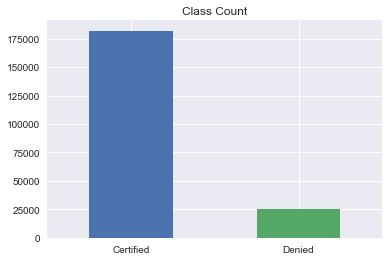

time: 123 ms


In [128]:
number_data.plot(kind='bar', title='Class Count', rot=0);

In [129]:
X=df2.drop(['case_status'], axis=1)
y=df2.case_status

time: 11 s


In [130]:
Counter(df2.case_status)

Counter({'Certified': 181933, 'Denied': 25649})

time: 25.7 ms


## Undersample

In [131]:
rus = RandomUnderSampler()
X_under, y_under = rus.fit_sample(X,y)

time: 40.7 s


In [132]:
Counter(y_under)

Counter({'Certified': 25649, 'Denied': 25649})

time: 14.4 ms


In [133]:
X_underdf=pd.DataFrame(X_under, columns = X.columns)
y_underdf=pd.DataFrame(y_under, columns=['case_status'])

time: 25.2 ms


In [134]:
df_under=X_underdf.join(y_underdf)

time: 8.39 s


In [135]:
df_under.head()

,class_of_admission_A-3,class_of_admission_A1/A2,class_of_admission_AOS/H-1B,class_of_admission_B-1,class_of_admission_B-2,class_of_admission_C-1,class_of_admission_C-3,class_of_admission_D-1,class_of_admission_E-1,class_of_admission_E-2,...,job_category_academic,job_category_business,job_category_engineer,job_category_finance/consulting/tax,job_category_h11,job_category_marketing/sales,job_category_medicine,job_category_programming,job_category_related,case_status
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Certified
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Certified
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Certified
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Certified
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Certified


time: 76.7 ms


# Store as CSV

In [136]:
# with open('clean_data1.pkl', 'wb') as picklefile:
#              pickle.dump(df_under, picklefile)

time: 748 µs


In [137]:
# with open("clean_data1.pkl", 'rb') as picklefile: 
#       df = pickle.load(picklefile)
# df.to_csv('clean_data1.csv')
# df.head()

time: 3.89 ms


# Modeling

In [138]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
import seaborn as sns
from sklearn.model_selection import cross_val_score
import matplotlib as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

time: 9.33 ms


In [139]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

time: 9.41 ms


## Train/Test Split on Random Subset of Data

In [140]:
mini_sample=df_under.sample(n=15000)
X=mini_sample.drop(['case_status'], axis=1)
y=mini_sample.case_status

time: 910 ms


In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

time: 479 ms


In [142]:
train_df=X_train.join(pd.DataFrame(y_train))
test_df=X_test.join(y_test)

time: 74 ms


## Apply Standard Scalar

In [143]:
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

time: 3.83 s


In [144]:
train_df_scaled=pd.DataFrame(X_train_scaled).join(y_train)
test_df_sclaed=pd.DataFrame(X_test_scaled).join(y_test)

time: 867 ms


## Compare Models- Confusion Matrices

In [145]:
models = [RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=10), DecisionTreeClassifier(max_depth=None),
          LogisticRegression(C=0.1), SGDClassifier(loss='log', random_state=42, alpha=0.01), naive_bayes.GaussianNB(),
         naive_bayes.BernoulliNB(), naive_bayes.MultinomialNB()]
model_names = ["Random Forest", "Decision Tree",'Bagging Classifier','Logistic','SGD-Log', 'Naive-Bayes Gaussian',
              'Naive-Bayes Bernoulli', 'Naive-Bayes Multinomial']

time: 3.71 ms


In [67]:
for clf, name in zip(models, model_names):
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    cm = print_confusion_matrix(conf_mat, ['Certified', 'Denied'])

ValueError: Shape of passed values is (3, 3), indices imply (4, 4)

time: 2.03 s


## Compare Models- ROC Curves

In [ ]:
roc_plotting_stuff = []
for clf, name in zip(models, model_names):
    clf.fit(X_train, y_train)
    preds = clf.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, preds[:,1], pos_label='Certified')
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))

In [ ]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.legend(loc='lower right', fontsize=9)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves");

In [70]:
categories = ['Certified', 'Certified-Expired', 'Denied']
y_binary = pd.DataFrame((label_binarize(y, classes=categories)),columns=categories)
n_classes = y_binary.shape[1]

time: 21.6 ms


In [71]:
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X, y_binary, test_size=0.4, random_state=42)

time: 452 ms


In [72]:
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled_bin = ss.transform(X_bin_train)
X_test_scaled_bin = ss.transform(X_bin_test)

time: 4.33 s


In [73]:
train_df_scaled=pd.DataFrame(X_train_scaled_bin).join(y_bin_train)
test_df_sclaed=pd.DataFrame(X_test_scaled_bin).join(y_bin_test)

time: 973 ms


In [77]:
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=42))
y_score = classifier.fit(X_train_scaled_bin, y_bin_train).decision_function(X_test_scaled_bin)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

ValueError: Can only tuple-index with a MultiIndex

time: 8min 2s


In [ ]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## Apply  Chosen Model

## Check How Many Data Points are Needed for Final Model

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(lm, X_train, y_train, cv= 4)

ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

learn_df = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})
learn_df

plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test size')
plt.legend(loc='lower right')
plt.ylim(-1,1)

## Retrain on Full Train Set and Get Accuracy Score on Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_underdf, y_underdf, test_size=0.4, random_state=42)

In [ ]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [ ]:
k_range = list(range(1, 100))
param_grid = dict(n_neighbors=k_range)

In [ ]:
# grid = GridSearchCV(KNN(), param_grid, cv=10, scoring='accuracy')
# grid.fit(X_train, y_train)
# grid.grid_scores_

In [ ]:
grid.predict([X_test])

In [ ]:
lm = LogisticRegression()
lm.fit(X_train, y_train)

In [ ]:
y_predict = lm.predict(X_train)
lm.score(X_train, y_train)